# **Import Library**

In [1]:
# Standar libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Pemrosesan teks & similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# File handling (jika diperlukan untuk Google Colab)
from google.colab import files

# **Data Loading**

Langkah ini bertujuan untuk **memuat dataset** yang diperlukan untuk membangun sistem rekomendasi. Karena proyek ini dijalankan di Google Colab, digunakan fungsi `files.upload()` dari modul `google.colab` untuk **mengunggah file CSV** dari komputer lokal ke lingkungan Colab.

In [2]:
# Upload file
uploaded = files.upload()

Saving tourism_rating.csv to tourism_rating.csv
Saving tourism_with_id.csv to tourism_with_id.csv


# **Data Understanding**

Pada tahap ini, kita mulai dengan **memuat dan memahami dataset** yang digunakan dalam sistem rekomendasi. Tujuan dari tahap ini adalah untuk mendapatkan wawasan awal terkait data yang akan digunakan, yang akan sangat berguna untuk proses **data preparation** dan **modeling** selanjutnya.

In [3]:
# Load datasets
rating = pd.read_csv('/content/tourism_rating.csv')
place = pd.read_csv('/content/tourism_with_id.csv')

In [4]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [6]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [7]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


## **Exploratory Data Analysis**

Langkah ini membantu untuk **memahami kondisi data** secara umum, baik dari sisi jumlah data, distribusi rating, dan jenis tempat wisata yang ada.

In [8]:
print('\nStatistik rating:')
print(rating.describe())


Statistik rating:
            User_Id      Place_Id  Place_Ratings
count  10000.000000  10000.000000   10000.000000
mean     151.292700    219.416400       3.066500
std       86.137374    126.228335       1.379952
min        1.000000      1.000000       1.000000
25%       77.000000    108.750000       2.000000
50%      151.000000    220.000000       3.000000
75%      226.000000    329.000000       4.000000
max      300.000000    437.000000       5.000000


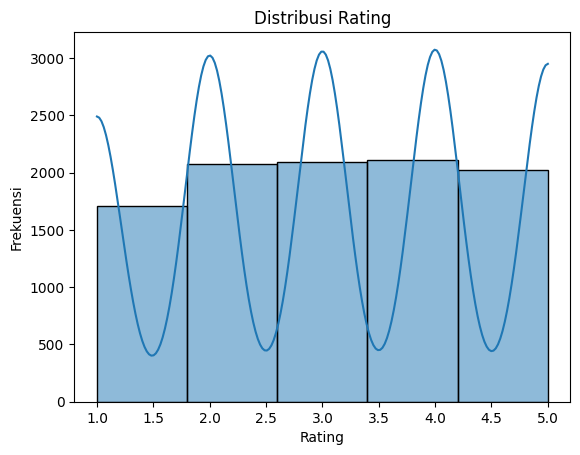

In [9]:
# Distribusi rating
sns.histplot(rating['Place_Ratings'], bins=5, kde=True)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

In [10]:
print('\nStatistik pengguna dan tempat yang dirating:')
print('Jumlah userID unik: ', len(rating.User_Id.unique()))
print('Jumlah placeID unik: ', len(rating.Place_Id.unique()))
print('Jumlah total data rating: ', len(rating))


Statistik pengguna dan tempat yang dirating:
Jumlah userID unik:  300
Jumlah placeID unik:  437
Jumlah total data rating:  10000


In [11]:
print('Banyak data tempat wisata: ', len(place.Place_Id.unique()))
print('Kategori tempat wisata yang tersedia: ', place.Category.unique())

Banyak data tempat wisata:  437
Kategori tempat wisata yang tersedia:  ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']


Kategori unik: ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']


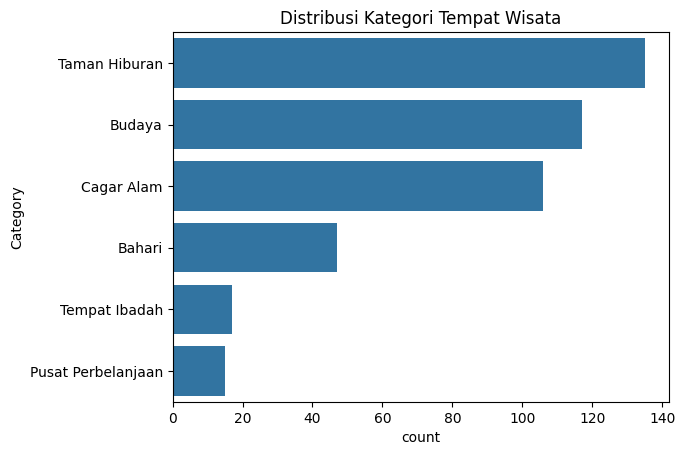

In [12]:
# Kategori tempat wisata
print('Kategori unik:', place.Category.unique())
sns.countplot(y=place['Category'], order=place['Category'].value_counts().index)
plt.title('Distribusi Kategori Tempat Wisata')
plt.show()

# **Data Preparation**

Pada tahap ini, kita **memperbaiki dan membersihkan** data yang telah dimuat sebelumnya agar siap digunakan dalam model rekomendasi. Dengan langkah ini, dataset menjadi lebih rapi dan siap digunakan dalam tahap berikutnya, yaitu **modeling** untuk sistem rekomendasi.

In [13]:
# Mengecek missing value pada data rating
rating.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [14]:
# Mengecek missing value pada data place
place.isnull().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [15]:
# Drop kolom yang memiliki missing value
place = place.dropna(axis=1)
place.isnull().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Coordinate,0
Lat,0
Long,0


In [16]:
# Cek duplikat
print("Jumlah data duplikat pada rating: ", rating.duplicated().sum())
print("Jumlah data duplikat pada place: ", place.duplicated().sum())

Jumlah data duplikat pada rating:  79
Jumlah data duplikat pada place:  0


In [17]:
# Menampilkan semua baris yang merupakan duplikat identik
duplikat_identik = rating[rating.duplicated(keep=False)]

# Menampilkan hasilnya
print(duplikat_identik)

      User_Id  Place_Id  Place_Ratings
25          1       328              2
29          1       328              2
120         5       321              3
129         5       321              3
134         5       301              2
...       ...       ...            ...
9690      291       431              4
9807      295       403              1
9814      295       403              1
9855      296       177              4
9860      296       177              4

[158 rows x 3 columns]


In [18]:
# Hapus duplikat identik
rating = rating.drop_duplicates()

In [19]:
# Cek duplikat
print("Jumlah data duplikat pada rating: ", rating.duplicated().sum())

Jumlah data duplikat pada rating:  0


In [20]:
# Mengonversi series menjadi list
place_id = place['Place_Id'].tolist()
place_name = place['Place_Name'].tolist()
place_category = place['Category'].tolist()

print('\nJumlah ID:', len(place_id))
print('Jumlah Nama:', len(place_name))
print('Jumlah Kategori:', len(place_category))


Jumlah ID: 437
Jumlah Nama: 437
Jumlah Kategori: 437


In [21]:
# Membuat DataFrame akhir untuk digunakan dalam sistem rekomendasi
tourism_df = pd.DataFrame({
    'id': place_id,
    'place_name': place_name,
    'category': place_category
})

# Menampilkan data akhir
tourism_df

,id,place_name,category
0,1,Monumen Nasional,Budaya
1,2,Kota Tua,Budaya
2,3,Dunia Fantasi,Taman Hiburan
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan
4,5,Atlantis Water Adventure,Taman Hiburan
...,...,...,...
432,433,Museum Mpu Tantular,Budaya
433,434,Taman Bungkul,Taman Hiburan
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan
435,436,Taman Flora Bratang Surabaya,Taman Hiburan


# **Model Development dengan Content Based Filtering**

Pada tahap ini, kita mengembangkan model rekomendasi dengan pendekatan **Content-Based Filtering** yang mengandalkan kesamaan kategori tempat wisata. Langkah ini menghasilkan model rekomendasi yang dapat memberikan daftar tempat wisata serupa berdasarkan kategori, yang merupakan contoh penerapan **content-based filtering**.

In [22]:
# Cek data
data = tourism_df
data.sample(5)

,id,place_name,category
244,245,Jendela Alam,Taman Hiburan
263,264,Gereja Katedral Santo Petrus Bandung,Tempat Ibadah
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan
85,86,Keraton Yogyakarta,Budaya
361,362,Danau Rawa Pening,Cagar Alam


## **TF-IDF Vectorizer**

**TF-IDF (Term Frequency-Inverse Document Frequency)** digunakan untuk mengubah teks kategori tempat wisata menjadi representasi numerik yang bisa digunakan dalam perhitungan kesamaan.

In [23]:
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Melakukan fit pada data kategori wisata
tfidf_vectorizer.fit(data['category'])

# Menampilkan nama-nama fitur (kategori wisata)
tfidf_vectorizer.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

In [24]:
# Transformasi ke dalam bentuk matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(data['category'])

# Ukuran matriks TF-IDF
tfidf_matrix.shape

(437, 10)

In [25]:
# Cek representasi matriks dalam bentuk dense
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.70710678]])

In [26]:
# Membuat DataFrame TF-IDF untuk interpretasi
pd.DataFrame(
tfidf_matrix.todense(),
columns=tfidf_vectorizer.get_feature_names_out(),
index=data.place_name
).sample(5, axis=1).sample(10, axis=0)

,cagar,hiburan,ibadah,taman,pusat
place_name,,,,,
"Bukit Paralayang, Watugupit",0.707107,0.000000,0.0,0.000000,0.0
Grojogan Watu Purbo Bangunrejo,0.000000,0.707107,0.0,0.707107,0.0
Pantai Ria Kenjeran,0.000000,0.000000,0.0,0.000000,0.0
Museum Gedung Sate,0.000000,0.000000,0.0,0.000000,0.0
Balai Kota Surabaya,0.000000,0.000000,0.0,0.000000,0.0
Monumen Tugu Pahlawan,0.000000,0.000000,0.0,0.000000,0.0
Stone Garden Citatah,0.000000,0.707107,0.0,0.707107,0.0
Museum Benteng Vredeburg Yogyakarta,0.000000,0.000000,0.0,0.000000,0.0
Taman Srigunting,0.000000,0.707107,0.0,0.707107,0.0


## **Cosine Similarity**

**Cosine similarity** dihitung menggunakan `cosine_similarity()` untuk mengukur kesamaan antar tempat wisata berdasarkan kategori mereka.

In [27]:
# Menghitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [28]:
# Membuat DataFrame cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['place_name'], columns=data['place_name'])

print('Shape:', cosine_sim_df.shape)

# Menampilkan sebagian similarity matrix
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


place_name,Tugu Proklamasi,Pantai Samas,Pantai Sundak,Desa Wisata Gamplong,Taman Air Mancur Menari Kenjeran
place_name,,,,,
Museum Geologi Bandung,1.0,0.0,0.0,0.0,0.0
Kota Lama Semarang,1.0,0.0,0.0,0.0,0.0
Bukit Bintang Yogyakarta,0.0,0.0,0.0,1.0,1.0
Surabaya North Quay,0.0,0.0,0.0,1.0,1.0
Flower Farm Setiya Aji,0.0,0.0,0.0,0.0,0.0
Taman Lalu Lintas Ade Irma Suryani Nasution,0.0,0.0,0.0,1.0,1.0
Taman Buah Surabaya,0.0,0.0,0.0,1.0,1.0
Monumen Batik Yogyakarta,1.0,0.0,0.0,0.0,0.0
Goa Rancang Kencono,0.0,0.0,0.0,0.0,0.0


## **Evaluasi**

Fungsi ini digunakan untuk **mengevaluasi kualitas rekomendasi** tempat wisata berdasarkan **kesamaan kategori** menggunakan pendekatan **Content-Based Filtering**. Jika `Precision@5 = 0.60`, berarti sekitar **60% kategori** dari rekomendasi **relevan** atau **mirip** dengan tempat wisata yang dijadikan acuan.

In [40]:
def evaluate_recommendation(place_name, top_k=5, similarity_data=cosine_sim_df, items=data[['place_name', 'category']]):
    """
    Evaluasi untuk rekomendasi berdasarkan kesamaan kategori dengan menggunakan cosine similarity
    Parameters:
    - place_name: nama tempat wisata yang dijadikan acuan
    - top_k: jumlah rekomendasi yang diinginkan
    - similarity_data: matriks similarity antar tempat wisata
    - items: DataFrame yang berisi place_name dan kategori

    Returns:
    - Precision@K yang dihitung berdasarkan overlap kategori
    """
    # Ambil rekomendasi tempat wisata berdasarkan nama tempat
    recommendations = tourism_recommendations(place_name, similarity_data, items, k=top_k)

    if recommendations.empty:
        print("Tidak ada rekomendasi ditemukan.")
        return

    # Ambil kategori dari tempat wisata input
    query_category = data[data['place_name'].str.lower() == place_name.lower()]['category'].values[0]
    query_categories = set(query_category.lower().replace(", ", ",").split(","))

    total_overlap = 0
    category_counts = []

    # Cek berapa banyak kategori yang cocok di setiap rekomendasi
    for _, row in recommendations.iterrows():
        rec_categories = set(row['category'].lower().replace(", ", ",").split(","))
        overlap = query_categories.intersection(rec_categories)
        total_overlap += len(overlap)
        category_counts.append(len(rec_categories))

    # Hitung Precision@K (rata-rata overlap kategori per rekomendasi)
    precision_at_k = total_overlap / sum(category_counts)

    print(f"Evaluasi untuk rekomendasi berdasarkan '{place_name}':")
    print(f"Kategori tempat wisata input: {query_categories}")
    print(f"Total overlap kategori: {total_overlap}")
    print(f"Precision@{top_k}: {precision_at_k:.2f}")

In [41]:
evaluate_recommendation("Gedung Sate")

Evaluasi untuk rekomendasi berdasarkan 'Gedung Sate':
Kategori tempat wisata input: {'budaya'}
Total overlap kategori: 5
Precision@5: 1.00


## **Fungsi Rekomendasi Tempat Wisata**

Fungsi `tourism_recommendations()` digunakan untuk memberikan rekomendasi tempat wisata berdasarkan kesamaan kategori. Fungsi ini menerima nama tempat wisata sebagai input, mencari tempat-tempat wisata yang memiliki kesamaan kategori tinggi dengan tempat tersebut, dan mengembalikan **k** rekomendasi tempat wisata teratas.

In [29]:
def tourism_recommendations(place_name, similarity_data=cosine_sim_df, items=data[['place_name', 'category']], k=5):
    """
    Memberikan rekomendasi tempat wisata berdasarkan kesamaan kategori
    Parameters:
    - place_name: nama tempat wisata yang dijadikan acuan
    - similarity_data: matriks similarity antar tempat wisata
    - items: DataFrame yang berisi place_name dan kategori
    - k: jumlah rekomendasi yang diinginkan

    Returns:
    - DataFrame berisi daftar tempat wisata yang mirip
    """
    index = similarity_data.loc[:, place_name].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(place_name, errors='ignore')  # menghindari return tempat yang sama
    return pd.DataFrame(closest).merge(items).head(k)

In [30]:
data[data.place_name.eq('Gedung Sate')]

,id,place_name,category
212,213,Gedung Sate,Budaya


In [31]:
tourism_recommendations('Gedung Sate')

,place_name,category
0,Monumen Nasional,Budaya
1,Candi Sewu,Budaya
2,Museum Benteng Vredeburg Yogyakarta,Budaya
3,Museum Satria Mandala,Budaya
4,Kyotoku Floating Market,Budaya


# **Model Development dengan Collaborative Filtering**

Pada tahap ini, kita mengembangkan model rekomendasi dengan pendekatan **Collaborative Filtering** menggunakan metode **Neural Network** untuk memprediksi rating yang belum diberikan oleh pengguna pada tempat wisata tertentu. Dengan langkah-langkah ini, kita membangun model **Collaborative Filtering** menggunakan neural network untuk memberikan rekomendasi yang lebih personal berdasarkan perilaku pengguna dalam memberikan rating pada tempat wisata.

## **Data Preparation**

Tahap ini mengubah ID pengguna dan tempat wisata menjadi representasi numerik (encoding) menggunakan dictionary yang memetakan ID asli ke ID yang lebih kecil (encoded) untuk digunakan dalam model neural network. Ini dilakukan dengan `user_to_user_encoded` dan `place_to_place_encoded` untuk memetakan ID asli ke ID numerik.

In [32]:
# Mengubah User_Id menjadi list tanpa nilai yang sama
user_ids = rating['User_Id'].unique().tolist()
print('list User_Id: ', user_ids)

# Melakukan encoding User_Id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)

list User_Id:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [33]:
# Mengubah Place_Id menjadi list tanpa nilai yang sama
place_ids = rating['Place_Id'].unique().tolist()
print('list Place_Id: ', place_ids)

# Melakukan encoding Place_Id
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
print('encoded Place_Id : ', place_to_place_encoded)

place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}
print('encoded Place_Id : ', place_to_place_encoded)

list Place_Id:  [179, 344, 5, 373, 101, 312, 258, 20, 154, 393, 103, 208, 89, 405, 41, 336, 67, 292, 222, 76, 428, 15, 246, 265, 21, 328, 307, 302, 48, 147, 2, 322, 23, 85, 371, 78, 111, 107, 185, 413, 389, 437, 105, 176, 407, 281, 167, 384, 426, 390, 367, 166, 18, 321, 262, 223, 17, 319, 310, 421, 202, 283, 250, 118, 54, 70, 33, 227, 86, 249, 131, 382, 193, 104, 24, 128, 134, 228, 237, 100, 198, 50, 376, 268, 242, 82, 348, 409, 88, 4, 377, 43, 91, 44, 14, 406, 383, 229, 290, 294, 309, 74, 97, 138, 436, 395, 300, 68, 55, 434, 9, 151, 61, 159, 397, 391, 301, 143, 27, 190, 346, 381, 368, 433, 420, 335, 115, 334, 219, 178, 266, 92, 64, 102, 257, 243, 116, 359, 121, 385, 398, 119, 298, 410, 224, 379, 255, 269, 213, 126, 192, 183, 129, 303, 296, 99, 148, 13, 247, 31, 77, 158, 306, 98, 235, 45, 173, 275, 25, 130, 164, 267, 56, 30, 238, 402, 196, 417, 304, 206, 211, 28, 264, 403, 253, 331, 188, 416, 378, 233, 95, 204, 225, 341, 145, 36, 168, 12, 280, 236, 42, 90, 75, 63, 205, 234, 284, 230, 1

In [34]:
# Mapping User_Id ke dataframe user
rating['user'] = rating['User_Id'].map(user_to_user_encoded)

# Mapping Place_Id ke dataframe place
rating['place'] = rating['Place_Id'].map(place_to_place_encoded)

# Menampilkan sample data setelah mapping
display(rating.head())

,User_Id,Place_Id,Place_Ratings,user,place
0,1,179,3,0,0
1,1,344,2,0,1
2,1,5,5,0,2
3,1,373,3,0,3
4,1,101,4,0,4


## **Membagi Data untuk Training dan Validasi**

Langkah ini adalah **tahapan penting sebelum training model Collaborative Filtering berbasis Neural Network**, memastikan data dalam format yang tepat dan terbagi secara adil untuk pelatihan dan evaluasi.

In [35]:
# Mengacak dataset
rating = rating.sample(frac=1, random_state=42)

# Membuat variabel x untuk mencocokkan data user dan tempat wisata
x = rating[['user', 'place']].values

# Mengubah rating menjadi nilai float (normalisasi)
min_rating = rating['Place_Ratings'].min()
max_rating = rating['Place_Ratings'].max()
y = rating['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[160 259]
 [ 16  54]
 [132 240]
 ...
 [163  74]
 [ 27  70]
 [220  63]] [0.25 0.25 1.   ... 1.   1.   0.5 ]


## **Proses Training**

Membangun arsitektur **Recommender System berbasis embeddings** untuk mempelajari hubungan antara pengguna dan tempat wisata dari data rating.

In [36]:
# Membangun model Neural Network
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        x = dot_user_place + user_bias + place_bias

        return tf.nn.sigmoid(x)

In [37]:
# Inisialisasi model
num_users = len(user_to_user_encoded)
num_places = len(place_to_place_encoded)
model = RecommenderNet(num_users, num_places, 50)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Training model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val)
)

Epoch 1/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6941 - root_mean_squared_error: 0.3430 - val_loss: 0.6942 - val_root_mean_squared_error: 0.3499
Epoch 2/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6875 - root_mean_squared_error: 0.3410 - val_loss: 0.6950 - val_root_mean_squared_error: 0.3505
Epoch 3/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6815 - root_mean_squared_error: 0.3363 - val_loss: 0.6958 - val_root_mean_squared_error: 0.3510
Epoch 4/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6752 - root_mean_squared_error: 0.3310 - val_loss: 0.6963 - val_root_mean_squared_error: 0.3514
Epoch 5/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6713 - root_mean_squared_error: 0.3295 - val_loss: 0.6973 - val_root_mean_squared_error: 0.3520
Epoch 6/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6667 - root_mean_squared_error: 0.3235 - val_loss: 0.6987 - val_root_mean_squared_error: 0.3530
Epoch 7/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3m

## **Evaluasi**

Untuk **mengevaluasi kinerja model** selama proses pelatihan (training) dan validasi dengan melihat **error** pada setiap epoch.

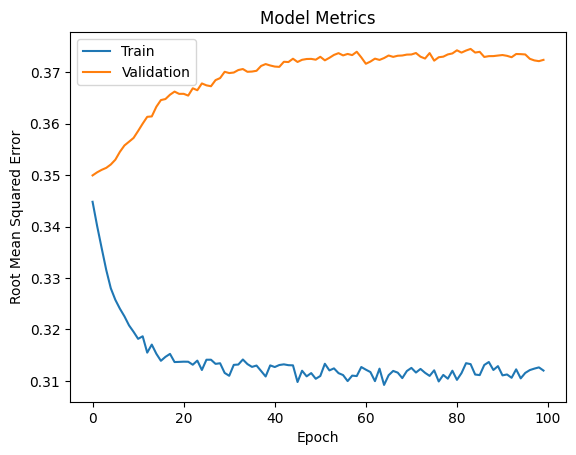

In [38]:
# Visualisasi metrik untuk mengevaluasi performa model
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Overfitting**

* Perbedaan antara kurva train dan validation menunjukkan bahwa model mulai overfit.
* Setelah itu, error pada validation set tidak membaik bahkan cenderung naik meski error pada training set tetap menurun.

## **Fungsi Rekomendasi Tempat Wisata**

Menampilkan **rekomendasi tempat wisata personalisasi** untuk satu user tertentu berdasarkan model **Collaborative Filtering**. Langkah ini menyimulasikan bagaimana sistem memberikan rekomendasi tempat wisata baru kepada user berdasarkan **riwayat kunjungan dan kesamaan preferensi** dari user lain menggunakan Collaborative Filtering.

In [39]:
# Menampilkan rekomendasi tempat wisata untuk user tertentu
user_id = rating['User_Id'].sample(1).iloc[0]
print(f"User ID yang dipilih: {user_id}")

# Tempat yang sudah dikunjungi user
places_visited_by_user = rating[rating['User_Id'] == user_id]
place_ids_visited = places_visited_by_user['Place_Id'].values
print(f"User ini telah mengunjungi {len(place_ids_visited)} tempat.")

# Menentukan tempat wisata yang belum dikunjungi oleh user
places_not_visited = tourism_df[~tourism_df['id'].isin(place_ids_visited)]
places_not_visited_encoded = [
    place_to_place_encoded[x] for x in places_not_visited['id'].values
    if x in place_to_place_encoded
]

# Siapkan data input untuk prediksi
user_encoded = user_to_user_encoded[user_id]
user_place_array = np.hstack([
    np.array([[user_encoded]] * len(places_not_visited_encoded)),
    np.array(places_not_visited_encoded).reshape(-1, 1)
])

# Prediksi rating untuk tempat yang belum dikunjungi
predicted_ratings = model.predict(user_place_array).flatten()

# Ambil top-N rekomendasi
top_n = 10
top_indices = predicted_ratings.argsort()[-top_n:][::-1]
recommended_encoded_ids = [places_not_visited_encoded[i] for i in top_indices]
recommended_place_ids = [place_encoded_to_place[i] for i in recommended_encoded_ids]

print('\n' + '=' * 30)
print('Places with HIGH ratings by the user:')
print('-' * 30)

# Tempat dengan rating tinggi oleh user tersebut
top_rated_places = places_visited_by_user.sort_values(by='Place_Ratings', ascending=False).head(5)
top_place_ids = top_rated_places['Place_Id'].values
top_places_info = tourism_df[tourism_df['id'].isin(top_place_ids)]

for row in top_places_info.itertuples():
    print(f"{row.place_name} : {row.category}")

print('\n' + '-' * 30)
print(f'Top {top_n} place recommendations:')
print('-' * 30)

# Tampilkan rekomendasi
recommended_places_info = tourism_df[tourism_df['id'].isin(recommended_place_ids)]
for row in recommended_places_info.itertuples():
    print(f"{row.place_name} : {row.category}")

User ID yang dipilih: 69
User ini telah mengunjungi 24 tempat.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

Places with HIGH ratings by the user:
------------------------------
Rumah Sipitung : Budaya
Curug Tilu Leuwi Opat : Cagar Alam
Museum Barli : Budaya
Gua Pawon : Cagar Alam
GPIB Immanuel Semarang (Gereja Blenduk) : Tempat Ibadah

------------------------------
Top 10 place recommendations:
------------------------------
Kawasan Malioboro : Taman Hiburan
Bukit Bintang Yogyakarta : Taman Hiburan
The World Landmarks - Merapi Park Yogyakarta : Taman Hiburan
Alun-alun Utara Keraton Yogyakarta : Budaya
Gumuk Pasir Parangkusumo : Taman Hiburan
Air Terjun Kedung Pedut : Cagar Alam
Desa Wisata Gamplong : Taman Hiburan
Obyek Wisata Goa Kreo : Cagar Alam
Taman Pelangi : Taman Hiburan
Taman Keputran : Taman Hiburan
